In [1]:
import argparse
import time
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from dataset.datasets import PFLDDatasets

# from models.mobilev3_pfld import PFLDInference

cudnn.benchmark = True
cudnn.determinstic = True
cudnn.enabled = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Re-importing the necessary libraries
from torch.utils.data import Dataset
from PIL import Image

class PFLDSingleImageDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        img = Image.open(self.img_path)
        # Convert the image to RGB format to ensure it only has three channels
        img = img.convert("RGB")
        # Resize the image to 112x112 before applying other transformations
        img = img.resize((112, 112), Image.BILINEAR)
        if self.transform:
            img = self.transform(img)
        
        # Assume that the ground truth is not known in this case
        landmark_gt = torch.zeros(106, 2)
        attribute = torch.zeros(6)
        
        return img, landmark_gt, attribute

# Now, when you create a PFLDSingleImageDataset, it will automatically convert the image to RGB and resize it to 112x112.


In [3]:
# Function to compute Non-Maximum Suppression Error (NME)
def compute_nme(preds, target):
    N = preds.shape[0]
    L = preds.shape[1]
    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 19:  # aflw
            interocular = 34
        elif L == 29:  # cofw
            interocular = np.linalg.norm(pts_gt[8, ] - pts_gt[9, ])
        elif L == 68:  # 300w
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        elif L == 98:
            interocular = np.linalg.norm(pts_gt[60, ] - pts_gt[72, ])
        elif L == 106:
            interocular = np.linalg.norm(pts_gt[35, ] - pts_gt[93, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt, axis=1)) / interocular

    return rmse

# Function to compute Area Under Curve (AUC)
def compute_auc(errors, failureThreshold, step=0.0001, showCurve=False):
    nErrors = len(errors)
    xAxis = list(np.arange(0., failureThreshold + step, step))
    ced = [float(np.count_nonzero([errors <= x])) / nErrors for x in xAxis]

    AUC = simps(ced, x=xAxis) / failureThreshold
    failureRate = 1. - ced[-1]

    if showCurve:
        plt.plot(xAxis, ced)
        plt.show()

    return AUC, failureRate 

In [4]:
# Validation function
def validate(wlfw_val_dataloader, plfd_backbone, show_image=False):
    plfd_backbone.eval()

    nme_list = []
    cost_time = []
    with torch.no_grad():
        for img, landmark_gt, _ in wlfw_val_dataloader:
            img = img.to(device)
            landmark_gt = landmark_gt.to(device)
            plfd_backbone = plfd_backbone.to(device)

            start_time = time.time()
            _, landmarks = plfd_backbone(img)
            cost_time.append(time.time() - start_time)

            landmarks = landmarks.cpu().numpy()
            landmarks = landmarks.reshape(landmarks.shape[0], -1, 2)  # landmark
            landmark_gt = landmark_gt.reshape(landmark_gt.shape[0], -1, 2).cpu().numpy()  # landmark_gt

            if show_image:
                show_img = np.array(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
                show_img = (show_img * 255).astype(np.uint8)
                np.clip(show_img, 0, 255)

                pre_landmark = landmarks[0] * [112, 112]

                cv2.imwrite("xxx.jpg", show_img)
                img_clone = cv2.imread("xxx.jpg")

                for (x, y) in pre_landmark.astype(np.int32):
                    cv2.circle(img_clone, (x, y), 1, (255, 0, 0),-1)
                cv2.imshow("xx.jpg", img_clone)
                cv2.waitKey(0)

            nme_temp = compute_nme(landmarks, landmark_gt)
            for item in nme_temp:
                nme_list.append(item)

        print('nme: {:.4f}'.format(np.mean(nme_list)))
        failureThreshold = 0.1
        auc, failure_rate = compute_auc(nme_list, failureThreshold, 0.0001, False)
        print('auc @ {:.10f} failureThreshold: {:.10f}'.format(failureThreshold, auc))
        print('failure_rate: {:}'.format(failure_rate))
        print("inference_cost_time: {0:4f}".format(np.mean(cost_time)))
        
    # Return the performance metrics
    return nme_list, auc, failure_rate

# def predict_landmarks(image_path, model_path, backbone="v2", show_image=False):
#     if backbone == "v2":
#         from models.pfld import PFLDInference, AuxiliaryNet
#     elif backbone == "v3":
#         from models.mobilev3_pfld import PFLDInference, AuxiliaryNet
#     elif backbone == "ghost":
#         from models.ghost_pfld import PFLDInference, AuxiliaryNet
#     elif backbone == "lite":
#         from models.lite import PFLDInference, AuxiliaryNet
#     else:
#         raise ValueError("backbone is not implemented")

#     checkpoint = torch.load(model_path, map_location=device)
#     plfd_backbone = PFLDInference().to(device)
#     plfd_backbone.load_state_dict(checkpoint['plfd_backbone'], strict=False)

#     transform = transforms.Compose([transforms.ToTensor()])
#     # Here we replace the dataset with a single image
#     wlfw_val_dataset = PFLDSingleImageDataset(image_path, transform)
#     wlfw_val_dataloader = DataLoader(wlfw_val_dataset, batch_size=1, shuffle=False, num_workers=0)

#     validate(wlfw_val_dataloader, plfd_backbone, show_image)# Function to compute Non-Maximum Suppression Error (NME)

nme: 5.2545
auc @ 0.1000000000 failureThreshold: 0.0000000000
failure_rate: 1.0
inference_cost_time: 0.006372
Model: v2
NME: 5.2545
AUC: 0.0000
Failure rate: 1.0000
---
nme: 4.6673
auc @ 0.1000000000 failureThreshold: 0.0000000000
failure_rate: 1.0
inference_cost_time: 0.008121
Model: v3
NME: 4.6673
AUC: 0.0000
Failure rate: 1.0000
---
nme: 6.5918
auc @ 0.1000000000 failureThreshold: 0.0000000000
failure_rate: 1.0
inference_cost_time: 0.004187
Model: lite
NME: 6.5918
AUC: 0.0000
Failure rate: 1.0000
---


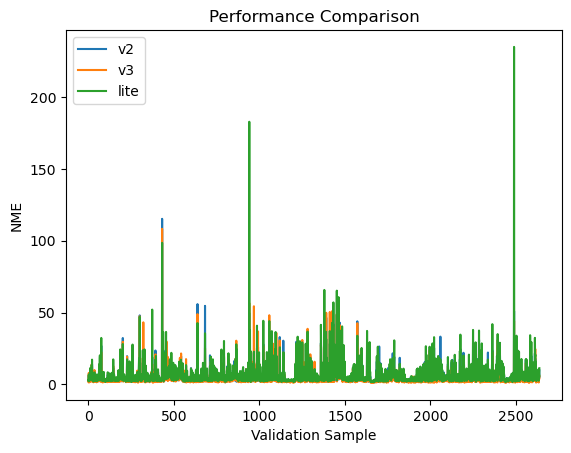

In [7]:
import matplotlib.pyplot as plt


def evaluate_and_plot_models(model_names, model_paths):
    # Define the possible model types
    model_types = ["v2", "v3", "ghost", "lite"]

    # Check that the model_names are valid
    for model_name in model_names:
        if model_name not in model_types:
            raise ValueError(
                f"Invalid model_name: {model_name}. Expected one of: {model_types}")

    # Check that the same number of model_names and model_paths are provided
    if len(model_names) != len(model_paths):
        raise ValueError(
            "model_names and model_paths must have the same length.")

    plt.figure()

    # Iterate over models
    for i, model_name in enumerate(model_names):
        model_path = model_paths[i]

        # Load the model and run the validation function
        if model_name == "v2":
            from models.pfld import PFLDInference, AuxiliaryNet
        elif model_name == "v3":
            from models.mobilev3_pfld import PFLDInference, AuxiliaryNet
        elif model_name == "ghost":
            from models.ghost_pfld import PFLDInference, AuxiliaryNet
        elif model_name == "lite":
            from models.lite import PFLDInference, AuxiliaryNet
        else:
            raise ValueError("backbone is not implemented")

        # Load model
        checkpoint = torch.load(model_path, map_location=device)
        plfd_backbone = PFLDInference().to(device)
        plfd_backbone.load_state_dict(
            checkpoint['plfd_backbone'], strict=False)

        transform = transforms.Compose([transforms.ToTensor()])
        wlfw_val_dataset = PFLDDatasets(
            './data/test_data/list.txt', transform, img_root=os.path.realpath('./data'))
        wlfw_val_dataloader = DataLoader(
            wlfw_val_dataset, batch_size=1, shuffle=False, num_workers=0)

        # Validate
        nme_list, auc, failure_rate = validate(
            wlfw_val_dataloader, plfd_backbone)

        # Print the performance metrics
        print(f'Model: {model_name}')
        print('NME: {:.4f}'.format(np.mean(nme_list)))
        print('AUC: {:.4f}'.format(auc))
        print('Failure rate: {:.4f}'.format(failure_rate))
        print('---')

        # Add to the plot
        plt.plot(nme_list, label=model_name)

    # Show the plot
    plt.title('Performance Comparison')
    plt.xlabel('Validation Sample')
    plt.ylabel('NME')
    plt.legend()
    plt.show()


# Usage:
model_paths = ["./checkpoint/v2/checkpoint_min_nme.pth",
               "./checkpoint/v3/v3.pth", "./checkpoint/lite/lite.pth"]
model_names = ["v2", "v3", "lite"]

# Assuming that you have a DataLoader `test_dataloader` for your test set
evaluate_and_plot_models(model_names, model_paths)
